In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline
sns.set(font_scale=1.5)

In [2]:
users = pd.read_csv("takehome_users.csv", 
                    encoding="latin8", 
                    parse_dates=["creation_time"]).sort_values("creation_time")
engagement = pd.read_csv("takehome_user_engagement.csv", 
                         encoding="latin8", 
                         parse_dates=["time_stamp"]).sort_values("time_stamp")

* convert unix timestamp to datetime

In [3]:
users.last_session_creation_time = pd.to_datetime(users['last_session_creation_time'],unit='s')

* 3177 users never logged in after creating an account
* around half of the users were invited by other users

In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 3860 to 6052
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 1.0+ MB


# User Data
* there are 417 orgs in users table

In [5]:
len(users.org_id.unique())

417

* Users by org are not evenly distributed
* lower org ID's have more users

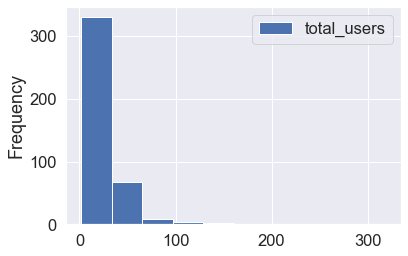

In [6]:
_ = users[["org_id", "object_id"]].groupby(["org_id"]).count().rename(
            {"object_id": "total_users"}, axis=1).plot(kind="hist")

# New Users by Month

March to May are the busiest months for user sign-up

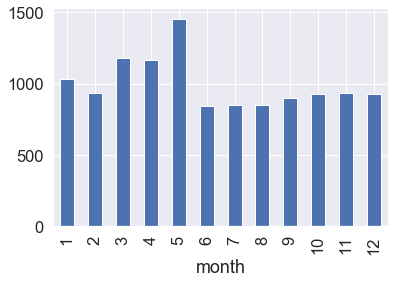

In [7]:
users["month"] = users.creation_time.dt.month
_ = users[["month", "object_id"]].groupby("month").count().plot(kind="bar", legend=False)

# New Users by Year/Month

There is a general increasing trend of user creation

Looks like we may have missing data in 2012/5 as there are few sign-ups for that month


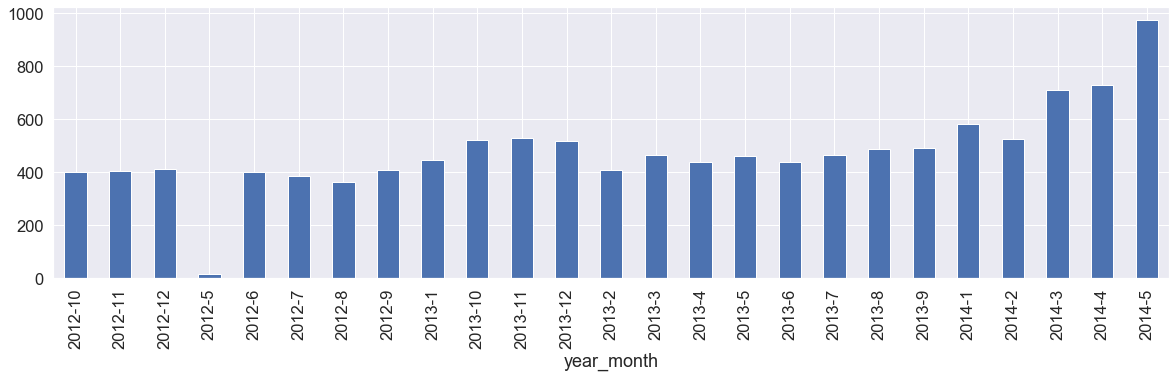

In [8]:
f, a = plt.subplots(1, 1, figsize=(20, 5))
users["year_month"] = users.creation_time.apply(lambda x: "-".join([str(x.year), str(x.month)]))
_ = users[["year_month", "object_id"]].groupby("year_month").count(). \
        plot(kind="bar", 
             legend=False,
             ax=a)

# Marketing Drip and Mailing List

Most people are not opted into the mailing list or enabled for marketing drip

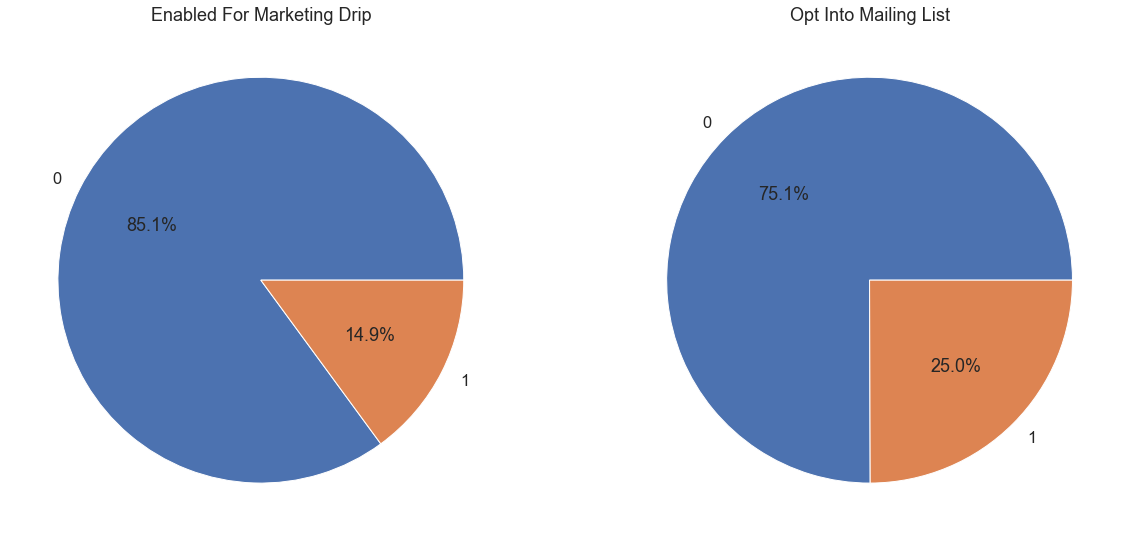

In [9]:
# marketing drip flag

marketing_drip = users[["enabled_for_marketing_drip", "object_id"]].groupby("enabled_for_marketing_drip"). \
                        count(). \
                        reset_index()
marketing_drip["drip_percentage"] = marketing_drip.object_id / marketing_drip.object_id.sum()



# mailing opt in flag
mailing_opt = users[["opted_in_to_mailing_list", "object_id"]].groupby("opted_in_to_mailing_list"). \
                    count(). \
                    reset_index()
mailing_opt["mailing_percentage"] = mailing_opt.object_id / mailing_opt.object_id.sum()



f, a = plt.subplots(1, 2, figsize=(20, 10))
_ = a[0].pie(marketing_drip.drip_percentage, labels = marketing_drip.enabled_for_marketing_drip, 
             autopct="%1.1f%%")
_ = a[0].set_title("Enabled For Marketing Drip")

_ = a[1].pie(mailing_opt.mailing_percentage, labels = mailing_opt.opted_in_to_mailing_list, 
             autopct="%1.1f%%")
_ = a[1].set_title("Opt Into Mailing List")


# f, a = plt.subplots(1, 1, figsize=(10, 10))
# users[["enabled_for_marketing_drip", "object_id"]].groupby("enabled_for_marketing_drip"). \
#             count().plot(kind="pie")

# Creation Source

* ORG_INVITE is the most popular creation source
* with the exception of google auth sign-up the other 3 categories are pretty even

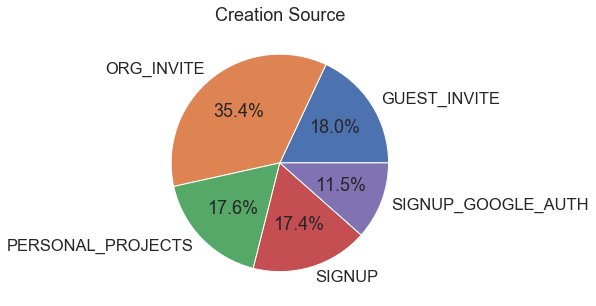

In [10]:
creation_source = users[["creation_source", "object_id"]].groupby("creation_source").count(). \
                        rename({"object_id": "total"}, axis=1).reset_index()
creation_source["source_percentage"] = creation_source.total / creation_source.total.sum()

f, a = plt.subplots(1, 1, figsize=(5, 5))
_ = a.set_title("Creation Source")
_ = a.pie(creation_source.source_percentage, labels=creation_source.creation_source,
         autopct="%1.1f%%")

# Invite Behavior

Around half of registered users are invited - this is matches up with previous graph if you add ORG_INVITE and GUEST_INVITE

In [11]:
users["invited"] = np.where(users.invited_by_user_id.notnull(), 1, 0)
print(f'Invited users: {users.invited.sum()} out of: {len(users)} ({users.invited.sum()/len(users)*100}%)')

Invited users: 6417 out of: 12000 (53.474999999999994%)


# Engagement Data

In [12]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 178140 to 70763
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 6.3 MB


* 8823 users with login record - this matches last_session_creation_time in users table

In [13]:
len(engagement.user_id.unique())

8823

# Users Don't Generally Log in Very Often

* 25% of users only logged in once
* 50% of users logged in 2 times or less
* 75% of users logged in 4 times or less

In [14]:
user_login_count = engagement[["user_id", "visited"]].groupby("user_id").count(). \
            rename({"visited": "login_count"}, axis=1). \
            reset_index()

user_login_count.groupby("login_count").count(). \
            rename({"user_id": "users"}, axis=1). \
            quantile([0.25, 0.50, 0.75])


,users
0.25,1.0
0.50,2.0
0.75,4.0


# Adopted User

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven­day period, identify which factors predict future user adoption.

In [15]:
# we are looking at logins per day so if we have multiple logins in the 
# same day for a person we can drop the duplicates
# NOTE: we shorted this by time_stamp when we loaded this dataframe already
engagement["date_str"] = engagement.time_stamp.dt.strftime("%Y-%m-%d")
engagement_deduped = engagement.drop_duplicates(subset=["user_id", "date_str"])


# filter out any users that have not logged in at least 3 times to make our processing
# faster
logins3 = engagement_deduped[["user_id", "visited"]].groupby("user_id").count()
logins3 = logins3[logins3.visited >= 3]. \
            rename({"visited": "login_count"}, axis=1).reset_index()


adopted_user_file = "adopted_users.csv"

adopted_users = pd.DataFrame()

index = 0
for user_id in logins3.user_id:
    user_engagement = engagement_deduped[engagement_deduped.user_id == user_id]

    if index % 100 == 0:
        print(f'Processing user id: {user_id} user has {len(user_engagement)} engagements')
    for i in np.arange(2, len(user_engagement)):
        # if starting engagement and ending enagement is < 7 days, we know we have
        # 3 engagements within that period
        if (user_engagement.iloc[i].time_stamp - user_engagement.iloc[i - 2].time_stamp).days < 7:
            adopted_users = adopted_users.append({"user_id": user_id, "adopted": True},
                                                ignore_index=True)
            break

    index += 1

adopted_users.user_id = adopted_users.user_id.astype(int)
adopted_users.adopted = adopted_users.adopted.astype(int)
adopted_users.to_csv(adopted_user_file, index=False)

print(f'Total adopted users: {len(adopted_users)}')
adopted_users.head()

Processing user id: 2 user has 14 engagements
Processing user id: 512 user has 134 engagements
Processing user id: 1099 user has 222 engagements
Processing user id: 1666 user has 6 engagements
Processing user id: 2220 user has 7 engagements
Processing user id: 2798 user has 7 engagements
Processing user id: 3226 user has 502 engagements
Processing user id: 3717 user has 8 engagements
Processing user id: 4269 user has 326 engagements
Processing user id: 4824 user has 4 engagements
Processing user id: 5385 user has 54 engagements
Processing user id: 5905 user has 29 engagements
Processing user id: 6463 user has 100 engagements
Processing user id: 7023 user has 286 engagements
Processing user id: 7624 user has 58 engagements
Processing user id: 8134 user has 22 engagements
Processing user id: 8666 user has 3 engagements
Processing user id: 9164 user has 146 engagements
Processing user id: 9696 user has 4 engagements
Processing user id: 10167 user has 17 engagements
Processing user id: 106

,adopted,user_id
0,1,2
1,1,10
2,1,20
3,1,33
4,1,42


In [16]:
# join the users DF with adopted_users

users_merged = users.merge(adopted_users, how='left', 
                           left_on="object_id", 
                           right_on="user_id")
users_merged.adopted = users_merged.adopted.fillna(0).astype(int)
users_merged[["object_id", "adopted", "user_id"]].sample(10)

,object_id,adopted,user_id
5175,8241,0,NaN
510,3850,0,NaN
1070,6237,0,NaN
5592,347,1,347.0
6239,11672,0,NaN
11992,5584,0,NaN
11596,9896,0,NaN
10450,3351,0,NaN
11719,11908,0,NaN
2272,397,1,397.0


### Double check our merge

sum of adopted should equal length of adopted_users

In [17]:
assert len(adopted_users) == users_merged.adopted.sum(), "merge error"

## Only small amount of our users are adopted users

only 13% - we have to take this into account when we have class imbalance

Using SVM might be a good strategy for classification since it takes onto account minority class misclassification better

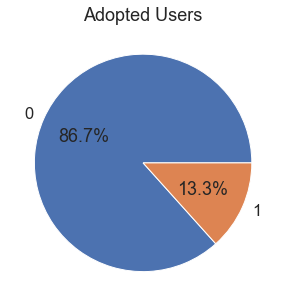

In [18]:
adopted_users = users_merged[["object_id", "adopted"]].groupby("adopted"). \
                        count().reset_index().rename({"object_id": "total"}, axis=1)
adopted_users["adopted_percentage"] = adopted_users.total / adopted_users.total.sum()

f, a = plt.subplots(1, 1, figsize=(5, 5))
_ = a.set_title("Adopted Users")
_ = a.pie(adopted_users.adopted_percentage, labels=adopted_users.adopted,
         autopct="%1.1f%%")